### IMPORTS

In [109]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
from collections import Counter
import pprint
from random import shuffle
from IPython.display import Image

### GLOBAL VARIABLES

In [110]:
client_ID = "bef34a7d63ba4ace8e7dc8c05de24591"

with open("secret.txt") as file:
    client_secret = file.read()[:-1]
    
sp = spotipy.Spotify(
    client_credentials_manager = SpotifyClientCredentials(
        "{}".format(client_ID), "{}".format(client_secret)))

host = "m11oiwplfr6aqk5svov48b40w"

find_URI = Image("find_spotify_URI.png", width = 400, height = 50)

genres = []

### USERS IDENTIFICATION

In [111]:
# spotify:user:1116826237//spotify:user:sedepa

In [112]:
def receive_users():
    print("Enter the Spotify URIs of the profiles you would like to link.\n")
    print("You can easily find your profile URI by following these 4 steps on the Spotify app:\n")
    display(find_URI)
    users_input = input("\n Paste your Spotify URIs ('spotify:user:username') here, separating them by '//':").split("//")

    users = {}
    for user in users_input:
        users[user[13:]] = sp.user(user[13:])["display_name"]
        
    return users

### OBTAIN USERS' PLAYLISTS

In [113]:
def get_user_playlists(users):
    
    users_playlists_names = {}
    users_playlists_names_IDs = {}
    
    for user in users:
        playlists = sp.user_playlists(user)
        playlists_names = []
        users_playlists_names_IDs[user] = {}
        
        for i, playlist in enumerate(playlists["items"]):
            playlists_names.append(playlist["name"])
            users_playlists_names_IDs[user][playlist["name"]] = playlist['uri'][17:]
            
        users_playlists_names[user] = playlists_names
        
    
    mygroup = {"users": {}}
    for user in users:
        mygroup["users"][user] = {} 
        
        
        
    for user in users:
        mygroup["users"][user]["playlists"] = input(
            """
            ·················································
            
            {} , enter the Spotify playlists you would like to upload, separated by '//'. 
                        
            These are all your playlists: 
    
            {} 
            
            
            If you want to submit all, just write "all"
                        
            """
            .format(users.get(user), users_playlists_names[user])).split("//")
    
        mygroup["users"][user]["genres"] = input(
            """
            ·················································
            
            {} , now select the genres of the songs for your new playlist.
                        
            You can select out of the following:
    
            {} 
            
            
            If you don't want to filter by genre, just write "any"
            
            Again, separate by '//'
                        
            """
            .format(users.get(user), genres)).split("//")


    mygroup["new_playlist_name"] = input(
            """
            ·················································
            
            And finally, write the name for your new combined playlist :D            
            
            """
            )
    
        
    return users_playlists_names_IDs, mygroup

### OBTAIN TRACKS INFO

In [114]:
def get_tracks_info(users_playlists_names_IDs, mygroup):
    users_playlists_tracks = {}
    for user in mygroup["users"].keys():
        tracks_info = []
        
        if mygroup["users"][user]["playlists"] == ["all"]:
            for playlist_ID in users_playlists_names_IDs[user].values():
                
                tracks_info.append(sp.user_playlist_tracks(user, playlist_id = playlist_ID))
        
        else:
            for playlist in mygroup["users"][user]["playlists"]:
                tracks_info.append(sp.user_playlist_tracks(user, 
                                                           playlist_id = users_playlists_names_IDs[user][playlist]))
    
        users_playlists_tracks[user] = tracks_info
        
    return users_playlists_tracks, mygroup

### OBTAIN FINAL TRACKS

In [115]:
def get_final_tracks(users_playlists_tracks, mygroup):
    
    final_tracks = {}
    
    final_track_names = []
    final_track_IDs = []
    final_track_artists = []

    for user in users_playlists_tracks:
        
        # Para cada usuario creo una lista de sus canciones con valores únicos. 
        # Esto lo hago para evitar que un usuario con la misma canción en distintas
        # playlists incluya varias veces la canción en la lista final, dándole mayor 
        # popularidad porque se repite entre sus listas, pero sin que realmente sea 
        # popular entre los distintos perfiles.
        
        user_track_names = []
        user_track_IDs = []
        user_track_artists = []
        
        for playlist in users_playlists_tracks[user]:
            for track in playlist["items"]:
                if track["track"]["name"] not in user_track_names:  # Aquí evito repetición.
                    if track["track"]["album"]["artists"] != []:  
                        artist_id = track["track"]["album"]["artists"][0]["external_urls"]["spotify"][32:]
                        artist_info = sp.artist(artist_id)
                        genre_in_artist = 0
                        if mygroup["users"][user]["genres"] == ["any"]:
                            user_track_names.append(track["track"]["name"])
                            user_track_IDs.append(track["track"]["id"])
                            user_track_artists.append(track["track"]["album"]["artists"][0]["name"])
                        else:
                            for genre in mygroup["users"][user]["genres"]:
                                if genre in artist_info["genres"]:
                                    genre_in_artist += 1
                            if genre_in_artist > 0:
                                user_track_names.append(track["track"]["name"])
                                user_track_IDs.append(track["track"]["id"]) 
                                user_track_artists.append(track["track"]["album"]["artists"][0]["name"])
                            
        for i in range(len(user_track_names)):
            final_track_names.append(user_track_names[i])
            final_track_IDs.append(user_track_IDs[i]) 
            final_track_artists.append(user_track_artists[i])        
            
    
    for i in range(len(final_track_names)):
        final_tracks[final_track_IDs[i]] = [final_track_names[i], final_track_artists[i]]
        
    
    # Hago este shuffle antes de ordenarlos por popularidad para evitar que las canciones con 
    # el mismo número de repeticiones se ordenen según el orden de introducción de los 
    # nombres de usuarios. Lo quiero aleatorio:
    
    shuffle(final_track_IDs)
    final_track_IDs_pop = [item for items, c in Counter(final_track_IDs).most_common() for item in [items] * c]
    
    final_track_IDs_unique = []
    
    for track_ID in final_track_IDs_pop:
        if track_ID not in final_track_IDs_unique:
            final_track_IDs_unique.append(track_ID)
            
    print(final_track_IDs[:10])
    print(final_track_IDs_pop[:10])
    
    return final_tracks, final_track_IDs_unique, final_track_IDs_pop, mygroup

### CREATE DATAFRAME FOR DJ

In [116]:
def create_dataframe(final_tracks, final_track_IDs_unique, final_track_IDs_pop, mygroup):

    tracks = []
    artists = []

    for ID in final_track_IDs_pop:
        if len(tracks) < 100:
            tracks.append(final_tracks.get(ID)[0])
            artists.append(final_tracks.get(ID)[1])

    final_tracks_df = pd.DataFrame(data = [final_track_IDs_pop[:100], tracks, artists],
                                   columns = range(100), 
                                   index = ["ID", "Track", "Artist"]).T
    
    display(final_tracks_df)

    return final_track_IDs_unique, mygroup

### CREATE PLAYLIST ON SPOTIFY

In [117]:
def create_playlist(final_track_IDs_unique, mygroup):

    token = util.prompt_for_user_token(host,
                               "playlist-modify-public",
                               client_id = "{}".format(client_ID),
                               client_secret = "{}".format(client_secret),
                               redirect_uri = "https://example.com/callback/")

    sp = spotipy.Spotify(auth = token)
    final_playlist = sp.user_playlist_create(host, mygroup["new_playlist_name"])

    sp.user_playlist_add_tracks(host, final_playlist["uri"][17:], final_track_IDs_unique[:100])

    final_playlist_url = final_playlist["external_urls"]["spotify"]
    
    print("""
          Here's your new combined playlist: 
          
          {}
          
          ENJOY!
          """.format(final_playlist["external_urls"]["spotify"])
          )
    

### PIPELINE

Enter the Spotify URIs of the profiles you would like to link.

You can easily find your profile URI by following these 4 steps on the Spotify app:



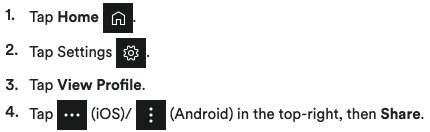


 Paste your Spotify URIs ('spotify:user:username') here, separating them by '//':spotify:user:1116826237//spotify:user:sedepa

            ·················································
            
            Iñigo Torres Uribe Echebarria , enter the Spotify playlists you would like to upload, separated by '//'. 
                        
            These are all your playlists: 
    
            ["Rock 'n' Run", 'Abstraéte', 'Piano piano, pianissimo', 'La colección', 'Canciones nuevas y tal', 'Infancia', 'Thank you, Spotify', 'Visitantes, se ruega escuchar'] 
            
            
            If you want to submit all, just write "all"
                        
            all

            ·················································
            
            Iñigo Torres Uribe Echebarria , now select the genres of the songs for your new playlist.
                        
            You can select out of the following:
    
            [] 
            
            
     

,ID,Track,Artist
0,0x8BlHc0tPoiY8zAzsD2Wa,Tiramisu de Limon,Joaquín Sabina
1,0x8BlHc0tPoiY8zAzsD2Wa,Tiramisu de Limon,Joaquín Sabina
2,5GFfRpAb26A57ao6nxjIIS,Man on Fire,Edward Sharpe & The Magnetic Zeros
3,5GFfRpAb26A57ao6nxjIIS,Man on Fire,Edward Sharpe & The Magnetic Zeros
4,0XTp7FvMMRslFWk4S7CFzX,Malabares,Estopa
5,0XTp7FvMMRslFWk4S7CFzX,Malabares,Estopa
6,4dNNPtOwiGJSTS86Z8bps2,Llévame al Baile,Pereza
7,4dNNPtOwiGJSTS86Z8bps2,Llévame al Baile,Pereza
8,10rA9ND4fP1MX0Nj0iobSp,Sea of Love,Cat Power
9,10rA9ND4fP1MX0Nj0iobSp,Sea of Love,Cat Power



          Here's your new combined playlist: 
          
          https://open.spotify.com/playlist/19EUmkhv7kwpYQ4aWthD2f
          
          ENJOY!
          


In [118]:
if __name__ == '__main__':
    
    users = receive_users()
    
    users_playlists_names_IDs, mygroup = get_user_playlists(users)
    
    users_playlists_tracks, mygroup = get_tracks_info(users_playlists_names_IDs, mygroup)
    
    final_tracks, final_track_IDs_unique, final_track_IDs, mygroup = get_final_tracks(users_playlists_tracks, mygroup)
    
    final_track_IDs_unique, mygroup = create_dataframe(
        final_tracks, final_track_IDs_unique, final_track_IDs, mygroup)
    
    create_playlist(final_track_IDs_unique, mygroup)
    